# Chapter 12: Custom Models and Training with TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

plt.style.use("dark_background")

1. TensorFlow gets its name because it revolves around tensors which flow from operation to operation. It's main features are:
    * **tensors** --> like NumPy arrays but with GPU support
    * It supports **distributed computing** across multiple devices & servers,
    * It can **optimize computations** for speed and memory usage using a **JIT compiler** that extracts the computation graph from a Python function, optimizes it, and running it efficiently (e.g. through parallelization)
    * Computation graphs can be exported so TensorFlow models can **run in any environment**
    * It implements **reverse mode autodiff** with `tf.GradientTape()`
    * Comes with **Keras**, a high level API for deep learning
 
    Other popular deep learning libraries include PyTorch by Facebook and JAX by Google.

2. TensorFlow's tensors are similar to NumPy arrays but TensorFlow is not a drop in replacement for NumPy. For example:
    * TensorFlow defaults to 32-bits, while NumPy uses 64-bit,
    * Some functions have different names (e.g. `tf.reduce_sum()` vs. `np.sum()`),
    * NumPy arrays are mutable, whereas TensorFlow tensors are not (`tf.Variable` is though).

3. Do you get the same result with `tf.range(10)` and `tf.constant(np.arange(10))`?

In [2]:
print(tf.range(10))
print(tf.constant(np.arange(10)))

tf.Tensor([0 1 2 3 4 5 6 7 8 9], shape=(10,), dtype=int32)
tf.Tensor([0 1 2 3 4 5 6 7 8 9], shape=(10,), dtype=int64)


4. Other than tensors, TensorFlow offers the following data structures:
    * `tf.SparseTensor`
    * `tf.TensorArray`
    * `tf.RaggedTensor`
    * String tensors (regular tensors of type `tf.string`)
    * Sets represented as regular tensors can be manipulated using `tf.sets` package
    * Queues: `tf.queue.FIFOQueue`, `tf.queue.PriorityQueue`, `tf.queue.RandomShuffleQueue`, `tf.queue.PaddingFIFOQueue`

5. When creating a custom loss function that has a hyper parameter, for example Huber loss where a given threshold is used, it is better to subclass `tf.keras.losses.Loss` rather than writing a Python function. Implementing the `get_config()` method ensures that the loss hyperparameters are saved when the model is saved.

6. Likewise for custom metrics, you can either write a Python function or subclass `tf.keras.metrics.Metric`, and if you want to save any metric hyperparameters you should use subclassing. Also, if the metric is stateful (i.e. it is a streaming metric that cannot simply be averaged over batches), you should also use subclassing, and write an `update_state()` method.

7. You should distinguish between models and layers, with models being the object that you train, layers are internal components of the model.

8. To use different optimizers for different parts of the NN, you must write your own training loop. A custom training loop might also be useful for debugging or understanding how training works.

9. Custom Keras components can contain arbitrary Python code, but ideally you want them to be convertible to TensorFlow functions. If you really need arbitrary python code to run you should wrap it in `tf.py_function`.

10. To ensure a python function can be converted to a TensorFlow function, do not call any external libraries and only use TensorFlow constructs e.g. use `tf.reduce_sum()` not `np.sum()`.

11. When would you need to create a dynamic Keras model (it will not compile any custom components to TF functions)?
    * debugging
    * include arbitrary Python code in the model or training
    How do you do that?
    * set `dynamic=True` when creating the model or `run_eagerly`=True when compiling it
    Why not make all your models dynamic?
    * Keras won't use any of TensorFlow's graph features making training and inference slow
    * also you won't be able to export the computational graph making the model less portable

## 12. Implementing a custom layer that performs *layer normalization*

a. The `build()` method should define two trainable weights $\alpha$ and $\beta$, both of shape `input_shape[-1:]` and data type `tf.float32`. $\alpha$ should be initialized with 1s, and $\beta$ with 0s.

b. The `call()` method should compute the mean $\mu$ and standard deviation $\sigma$ of each instance’s features. For this, you can use `tf.nn.moments(inputs, axes=-1, keepdims=True)`, which returns the mean $\mu$ and the variance $\sigma^2$ of all instances (compute the square root of the variance to get the standard deviation). Then the function should compute and return $\alpha \otimes ( X - \mu ) / ( \sigma + \epsilon ) + \beta$, where $\otimes$ represents itemwise multiplication (*) and $\epsilon$ is a smoothing term (a small constant to avoid division by zero, e.g., 0.001).

c. Ensure that your custom layer produces the same (or very nearly the same) output as the `tf.keras.layers.LayerNormalization` layer.

In [3]:
class LayerNormalization(tf.keras.layers.Layer):
    def build(self, batch_input_shape):
        self.alpha = self.add_weight(
            name="alpha",
            shape=batch_input_shape[-1:],
            initializer="ones",
            dtype=tf.float32,
        )
        self.beta = self.add_weight(
            name="beta",
            shape=batch_input_shape[-1:],
            initializer="zeros",
            dtype=tf.float32,
        )
        super().build(batch_input_shape)

    def call(self, X):
        mean, variance = tf.nn.moments(X, axes=-1, keepdims=True)
        sd = tf.sqrt(variance + tf.keras.backend.epsilon())
        return (self.alpha * ((X - mean) / sd)) + self.beta

In [4]:
test_batch = tf.random.normal((2, 3))
assert tf.reduce_all(
    tf.abs(
        LayerNormalization()(test_batch)
        - tf.keras.layers.LayerNormalization()(test_batch)
    )
    < 0.01
)

## 13. Using a custom training loop for the Fashion MNIST dataset

a. Display the epoch, iteration, mean training loss, and mean accuracy over each epoch (updated at each iteration), as well as the validation loss and accuracy at the end of each epoch.

b. Try using a different optimizer with a different learning rate for the upper layers and the lower layers.

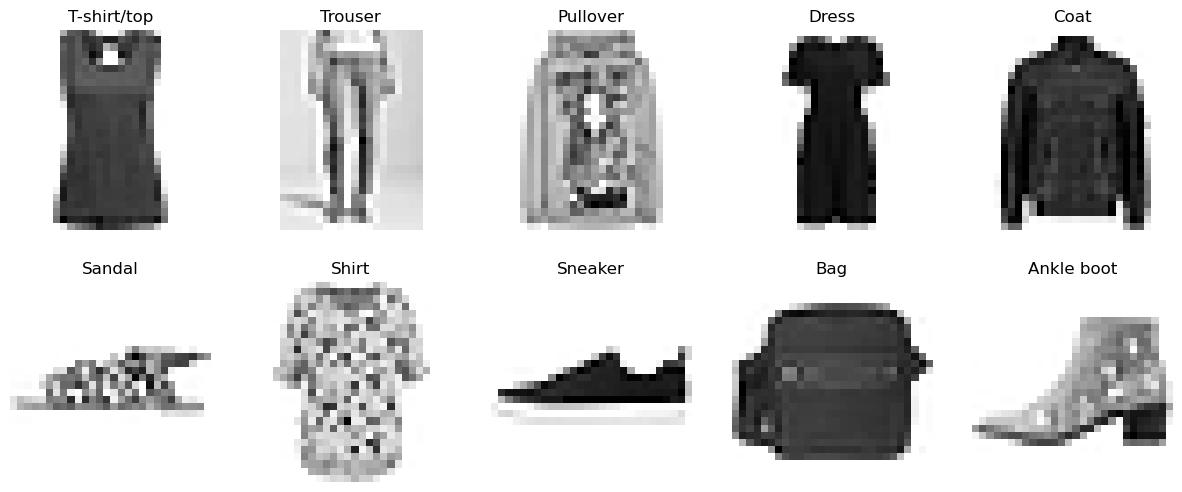

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=X_test.shape[0]
)
class_labels = (
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_train[y_train == i][0], cmap="binary")
    ax.set_title(class_labels[i])
    ax.axis("off")

In [6]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)

lower_layers = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(15, activation="relu", kernel_initializer="he_normal")
        for _ in range(2)
    ]
)
upper_layers = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=[28, 28]),
        norm_layer,
        tf.keras.layers.Flatten(),
        lower_layers,
        upper_layers,
    ]
)

In [7]:
n_epochs = 3
batch_size = 64
n_steps = len(X_train) // batch_size
upper_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
lower_optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
mean_loss = tf.keras.metrics.Mean(name="mean_loss")
accuracy_fn = tf.keras.metrics.sparse_categorical_accuracy
mean_accuracy = tf.keras.metrics.Mean(name="mean_accuracy")


def random_batch(X, y):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]


def print_status_bar(step, loss, accuracy):
    if step < n_steps:
        print(
            f"\r{step}/{n_steps} - mean_training_loss: {loss:.4f} - mean_training_accuracy: {accuracy:.4f}",
            end="",
        )
    else:
        y_pred = model(X_valid)
        val_loss = tf.reduce_mean(loss_fn(y_valid, y_pred))
        val_acc = tf.reduce_mean(accuracy_fn(y_valid, y_pred))
        print(f"\rval_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}" + 100 * " ")


for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train, y_train)
        with tf.GradientTape(persistent=True) as tape:
            y_pred = model(X_batch, training=True)
            loss = tf.reduce_mean(loss_fn(y_batch, y_pred))

        for optimizer, layers in zip(
            [lower_optimizer, upper_optimizer], [lower_layers, upper_layers]
        ):
            optimizer.apply_gradients(
                zip(
                    tape.gradient(loss, layers.trainable_variables),
                    layers.trainable_variables,
                )
            )

        mean_loss(loss)
        mean_accuracy(accuracy_fn(y_batch, y_pred))

        print_status_bar(step, mean_loss.result(), mean_accuracy.result())

    for metric in [mean_loss, mean_accuracy]:
        metric.reset_state()

Epoch 1/3
val_loss: 0.4766 - val_acc: 0.8326                                                                                                    
Epoch 2/3
val_loss: 0.4403 - val_acc: 0.8454                                                                                                    
Epoch 3/3
val_loss: 0.4153 - val_acc: 0.8528                                                                                                    


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
test accuracy: 0.8402000069618225


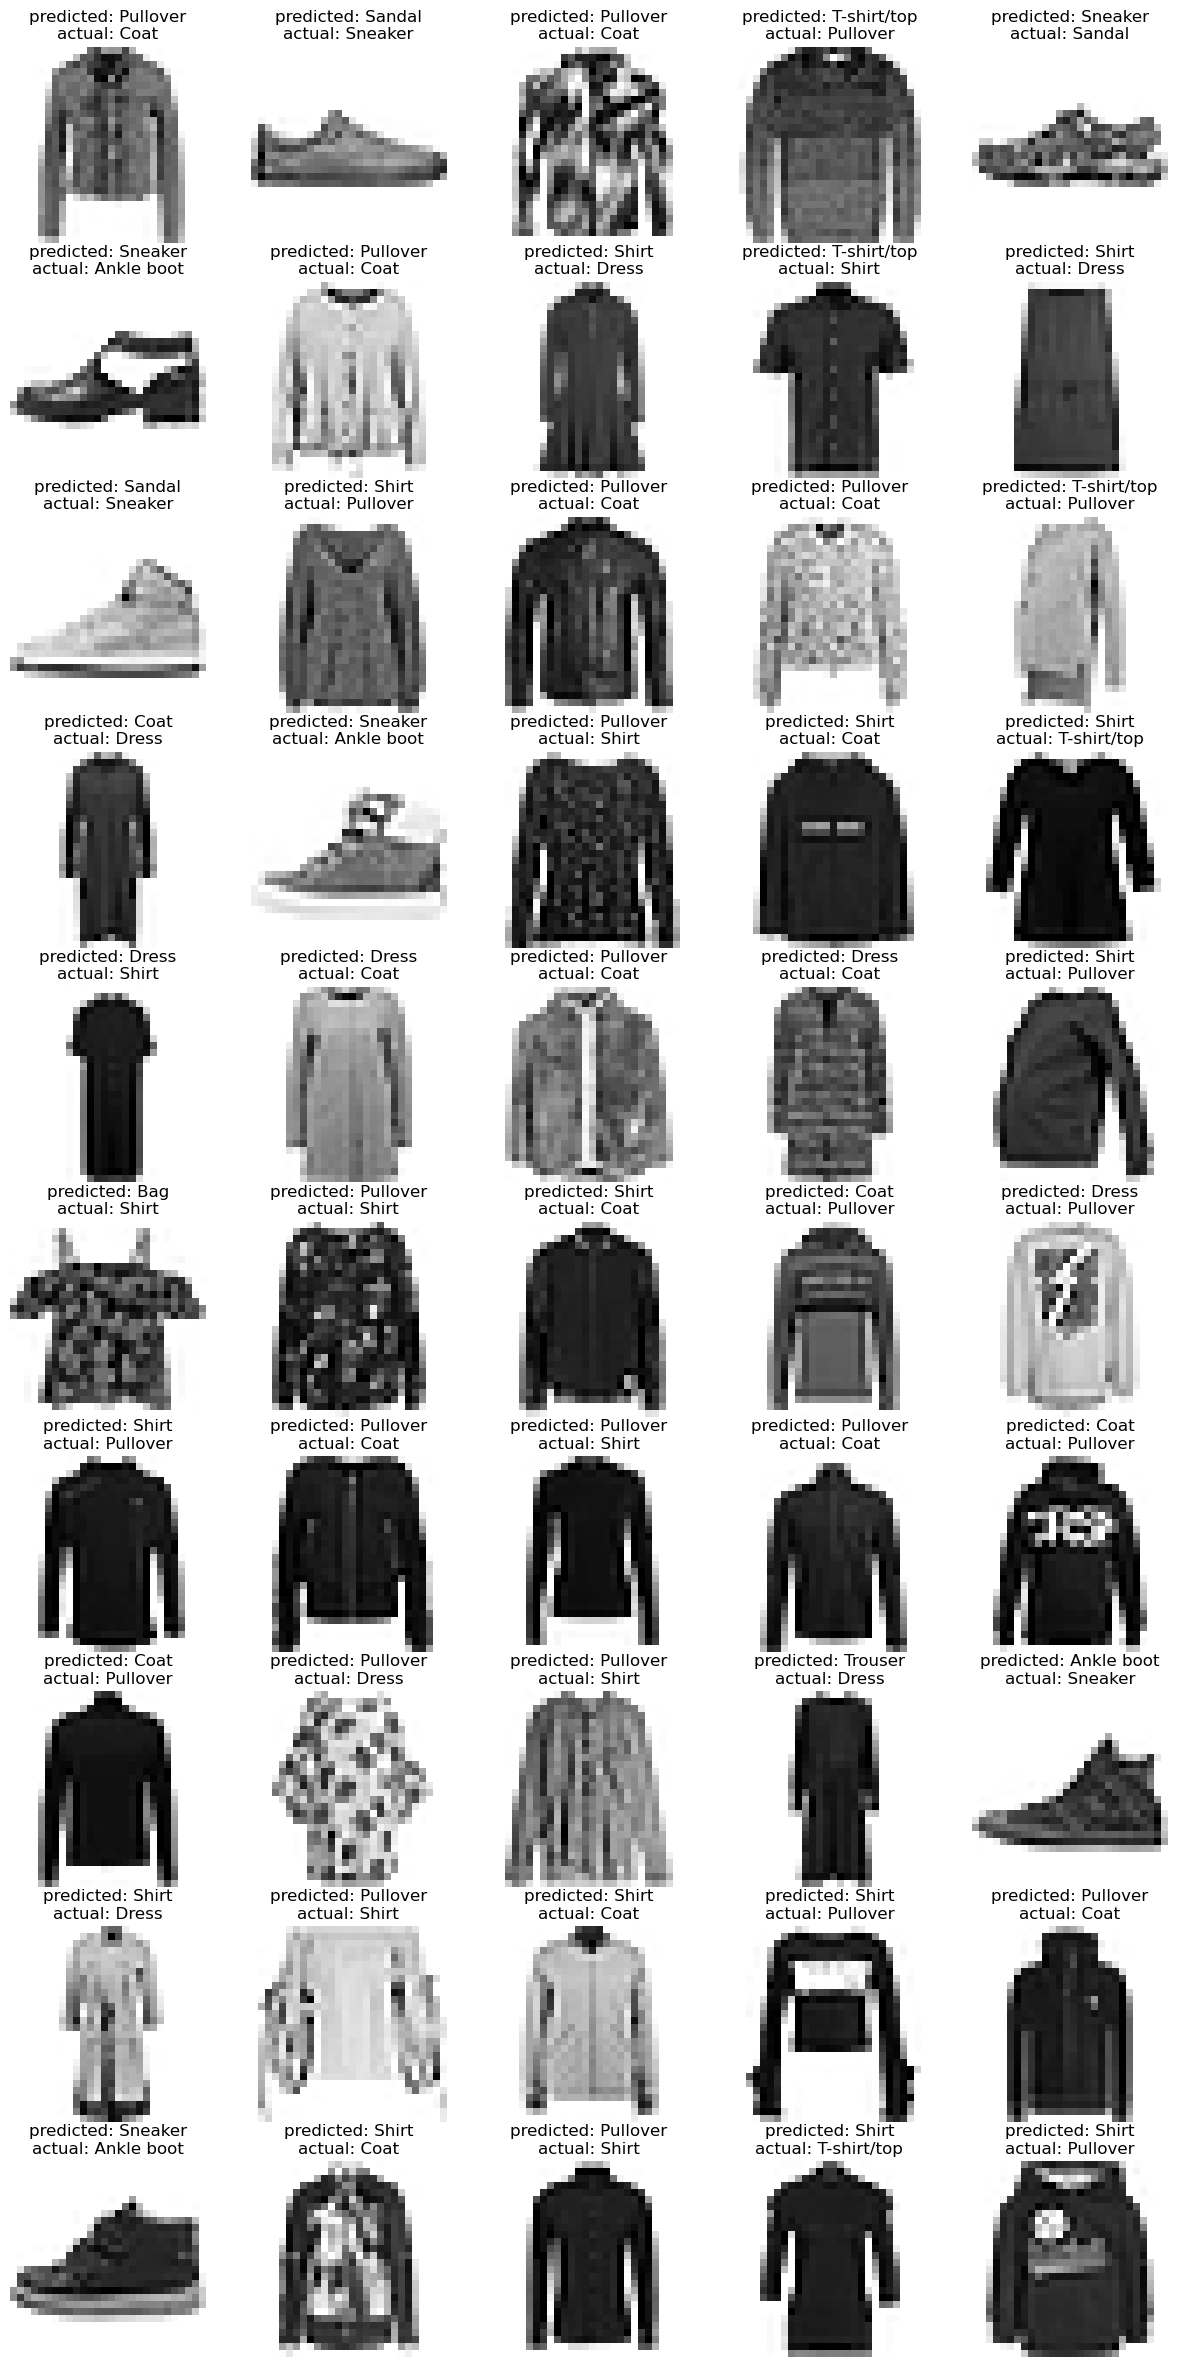

In [8]:
y_pred = model.predict(X_test)
print(f"test accuracy: {tf.reduce_mean(accuracy_fn(y_test, y_pred)).numpy()}")
y_pred = tf.argmax(y_pred, axis=-1).numpy()

incorrect_idx = y_pred != y_test

fig, axs = plt.subplots(10, 5, figsize=(15, 30))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_test[incorrect_idx][i], cmap="binary")
    ax.set_title(
        f"predicted: {class_labels[y_pred[incorrect_idx][i]]}\nactual: {class_labels[y_test[incorrect_idx][i]]}"
    )
    ax.axis("off")